In [11]:
import pandas as pd
import numpy as np
import pyod
import seaborn as sns
import matplotlib.pyplot as pyplot
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn import preprocessing
from pyod.utils.data import evaluate_print

from pyod.models.pca import PCA
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM

from pyod.models.lof import LOF 
from pyod.models.cof import COF
from pyod.models.cblof import CBLOF
from pyod.models.loci import LOCI
from pyod.models.hbos import HBOS
from pyod.models.knn import KNN
from pyod.models.sod import SOD

np.set_printoptions(precision=3)

In [2]:
testing_set = pd.read_csv('../Unbalanced_Samples/Sample_60K.csv',sep=',',header=0)

import csv
with open('../Unbalanced_Samples/Sample_60K.csv', newline='') as f:
  csv_reader = csv.reader(f)
  header = next(csv_reader)

for i in range(len(header)):
    header[i] = header[i]+" ("+str(i)+")"
print(header)

['Unnamed: 0 (0)', 'Flow ID (1)', 'Src IP (2)', 'Src Port (3)', 'Dst IP (4)', 'Dst Port (5)', 'Protocol (6)', 'Timestamp (7)', 'Flow Duration (8)', 'Tot Fwd Pkts (9)', 'Tot Bwd Pkts (10)', 'TotLen Fwd Pkts (11)', 'TotLen Bwd Pkts (12)', 'Fwd Pkt Len Max (13)', 'Fwd Pkt Len Min (14)', 'Fwd Pkt Len Mean (15)', 'Fwd Pkt Len Std (16)', 'Bwd Pkt Len Max (17)', 'Bwd Pkt Len Min (18)', 'Bwd Pkt Len Mean (19)', 'Bwd Pkt Len Std (20)', 'Flow Byts/s (21)', 'Flow Pkts/s (22)', 'Flow IAT Mean (23)', 'Flow IAT Std (24)', 'Flow IAT Max (25)', 'Flow IAT Min (26)', 'Fwd IAT Tot (27)', 'Fwd IAT Mean (28)', 'Fwd IAT Std (29)', 'Fwd IAT Max (30)', 'Fwd IAT Min (31)', 'Bwd IAT Tot (32)', 'Bwd IAT Mean (33)', 'Bwd IAT Std (34)', 'Bwd IAT Max (35)', 'Bwd IAT Min (36)', 'Fwd PSH Flags (37)', 'Bwd PSH Flags (38)', 'Fwd URG Flags (39)', 'Bwd URG Flags (40)', 'Fwd Header Len (41)', 'Bwd Header Len (42)', 'Fwd Pkts/s (43)', 'Bwd Pkts/s (44)', 'Pkt Len Min (45)', 'Pkt Len Max (46)', 'Pkt Len Mean (47)', 'Pkt Len 

C:\Users\andre\Anaconda3\envs\security\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#transforma dados categóricos em números
for f in testing_set.columns: 
    if testing_set[f].dtype=='object': 
        label = preprocessing.LabelEncoder() 
        label.fit(list(testing_set[f].values)) 
        testing_set[f] = label.transform(list(testing_set[f].values))
    
testingSet = testing_set.values
np.random.shuffle(testingSet)

testingSet = testingSet.astype(float)

for i in range (2*10**4-1, 0, -1):
    for j in range(0, 6):
        testingSet[i, j] = float(testingSet[i, j])
        if (np.isinf(testingSet[i, j]) or np.isnan(testingSet[i, j])):
            testingSet = np.delete(testingSet, i, axis=0)

y_test = testingSet[:, 84].astype(int)

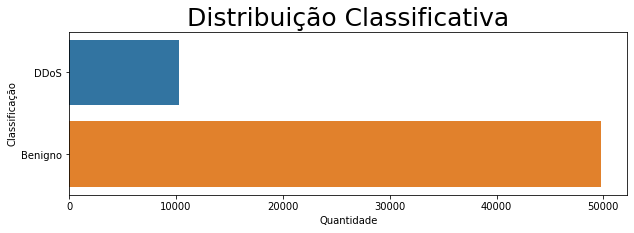

In [4]:
pyplot.subplots(figsize=(10, 3))
distribution = pd.DataFrame({"Classificação": ["DDoS","Benigno"],
                             "Quantidade":  [y_test.sum() , y_test.size - y_test.sum()]})
sns.barplot(data=distribution, y="Classificação", x="Quantidade").set_title("Distribuição Classificativa", fontsize=25)
pyplot.show()

In [5]:
testing_set = pd.DataFrame(testingSet)
testing_set.columns = header
corrmat = testing_set.corr()
top_corr_features = corrmat.index

In [6]:
#Features codificadas pelo label enconder: 17 16 7 4 2 1 0
#Feaatures sempre 0: 67, 66, 65, 64, 63, 62, 40, 39
#features com correlação próxima de zero, vide loop abaixo: 73, 71, 70, 50, 42, 34, 12, 10 
droppingList = [67, 66, 65, 64, 63, 62, 40, 39, 17, 16, 7, 4, 2, 1, 0]
droppedFeatures = droppingList

cm = testing_set[top_corr_features].corr().values
for i in (droppingList):
    testingSet = np.delete(testingSet, i, axis=1)
    header = np.delete(header, i, axis=0)
    
    cm = np.delete(cm, i, axis = 0)
    cm = np.delete(cm, i, axis = 1)

tolerance = 0.4
for i in range(cm.shape[0]-1, 0, -1):
    if cm[cm.shape[0]-1, i] >= -tolerance and cm[cm.shape[0]-1, i] <= tolerance:
        if i not in droppingList:
            droppedFeatures.append(i)
            testingSet = np.delete(testingSet, i, axis=1)
            header = np.delete(header, i, axis=0)
print("Features dropadas: ")
print(droppedFeatures)

Features dropadas: 
[67, 66, 65, 64, 63, 62, 40, 39, 17, 16, 7, 4, 2, 1, 0, 68, 61, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 15, 14, 13, 12, 11, 10, 9, 8, 6, 5, 3]


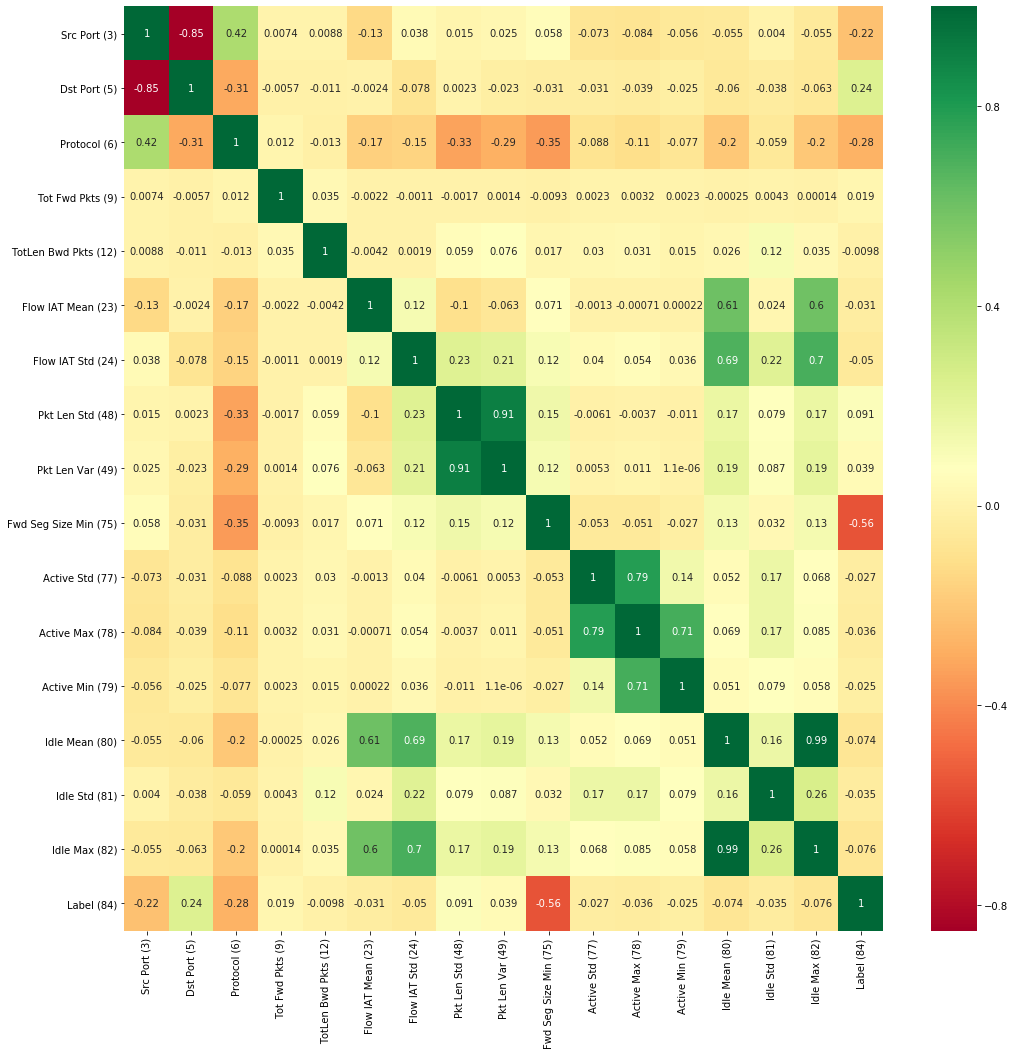

In [7]:
testing_set = pd.DataFrame(testingSet)
testing_set.columns = header
corrmat = testing_set.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(testingSet.shape[1], testingSet.shape[1]))
#plot heat map
g=sns.heatmap(testing_set[top_corr_features].corr(),annot=True,cmap="RdYlGn")
g.set_ylim(g.get_ylim()[0]+0.5, g.get_ylim()[1]-0.5)

testingSet = np.delete(testingSet, 84-len(droppedFeatures), axis=1)  #deleta o label
header = np.delete(header, 84-len(droppedFeatures), axis=0)

In [8]:
#Aplica a padronização z-score
"""testingSetSaved = testingSet

mi = np.mean(testingSet)
sigma = np.std(testingSet)
testingSet = (testingSet - mi) / sigma"""

'testingSetSaved = testingSet\n\nmi = np.mean(testingSet)\nsigma = np.std(testingSet)\ntestingSet = (testingSet - mi) / sigma'

In [9]:
outliers_fraction = 0.17
def testMethod(clf, clf_name):
    clf.fit(testingSet)

    #####################################################################

    y_test_pred = clf.predict(testingSet)  # outlier labels (0 or 1)
    y_test_scores = clf.decision_function(testingSet)  # outlier scores

    #####################################################################

    print("\nOn Test Data - "+clf_name+":")
    truePositive = 0
    trueNegative = 0
    falsePositive = 0
    falseNegative = 0

    for i in range(y_test.size):
        if(y_test[i] == 1 and y_test_pred[i] == 1):
            truePositive = truePositive+1
        elif (y_test[i] == 0 and y_test_pred[i] == 0):
            trueNegative = trueNegative+1
        elif (y_test[i] == 0 and y_test_pred[i] == 1):
            falsePositive = falsePositive+1
        else:
            falseNegative = falseNegative+1

    print(truePositive, " | ", falsePositive)
    print(falseNegative, " | ", trueNegative,"\n")

    evaluate_print(clf_name, y_test, y_test_scores)

    #####################################################################

    fpr, tpr, threshold = metrics.roc_curve(y_test, y_test_scores)
    roc_auc = metrics.auc(fpr, tpr)

    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic - '+clf_name)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()



On Test Data - PCA:
2995  |  7205
7261  |  42539 

PCA ROC:0.6284, precision @ rank n:0.295


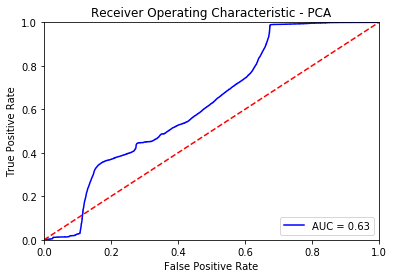

C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (308.429446475915029 > 151.272125878958889). You may want to try with a higher value of support_fraction (current value: 0.503).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (309.368759022650408 > 183.802380840561710). You may want to try with a higher value of support_fraction (current value: 0.503).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (327.356189502588791 > 76.892641480899627). You may want to try with a higher value of support_fraction (current


On Test Data - MCD:
2964  |  7236
7292  |  42508 

MCD ROC:0.7354, precision @ rank n:0.2898


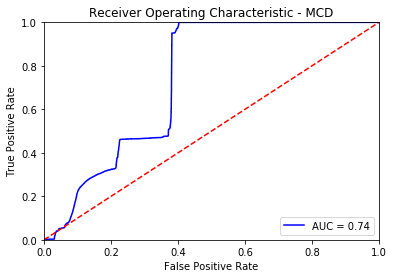


On Test Data - OCSVM:
1952  |  8247
8304  |  41497 

OCSVM ROC:0.5088, precision @ rank n:0.1913


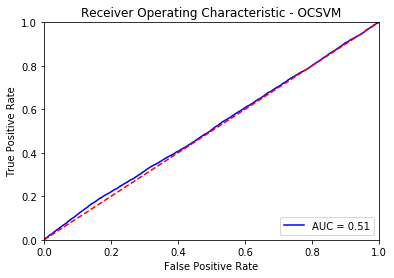

In [12]:
#Linear Models
classifiers = {
    'PCA': PCA(contamination= outliers_fraction),
    'MCD': MCD(contamination= outliers_fraction),
    'OCSVM': OCSVM(contamination= outliers_fraction)
}

for i, (clf_name, clf) in enumerate(classifiers.items()):
    testMethod(clf, clf_name)


On Test Data - KNN n=1:
0  |  0
10256  |  49744 

KNN n=1 ROC:0.5, precision @ rank n:0.0


C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


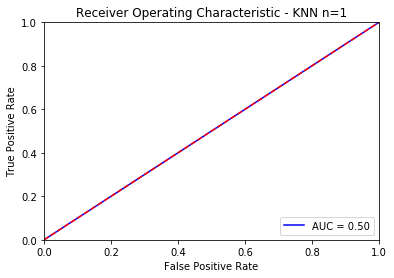


On Test Data - KNN n=3:
844  |  8657
9412  |  41087 

KNN n=3 ROC:0.5725, precision @ rank n:0.0943


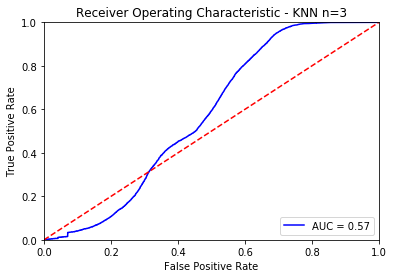


On Test Data - KNN n=5:
960  |  8894
9296  |  40850 

KNN n=5 ROC:0.5761, precision @ rank n:0.101


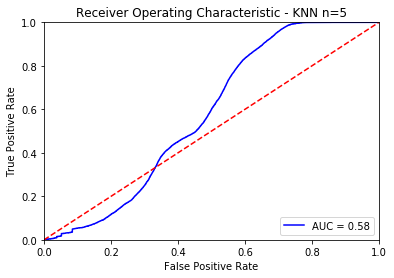


On Test Data - KNN n=7:
1001  |  8987
9255  |  40757 

KNN n=7 ROC:0.5774, precision @ rank n:0.1019


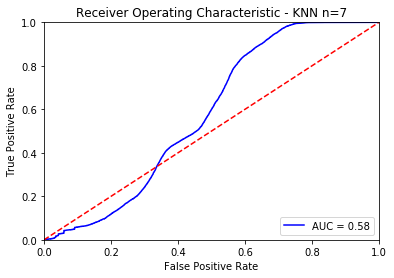


On Test Data - KNN n=9:
1007  |  9011
9249  |  40733 

KNN n=9 ROC:0.5778, precision @ rank n:0.1014


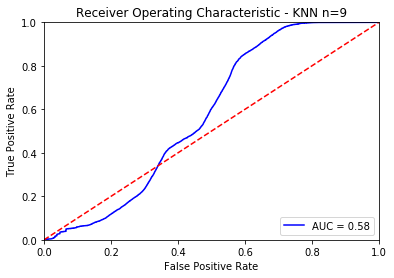


On Test Data - KNN n=11:
1003  |  9032
9253  |  40712 

KNN n=11 ROC:0.5783, precision @ rank n:0.1017


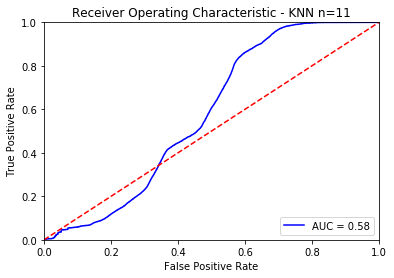


On Test Data - KNN n=13:
1002  |  9065
9254  |  40679 

KNN n=13 ROC:0.5786, precision @ rank n:0.1011


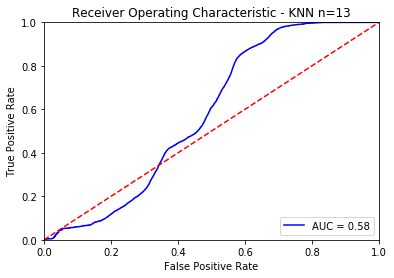


On Test Data - KNN n=15:
1011  |  9075
9245  |  40669 

KNN n=15 ROC:0.5788, precision @ rank n:0.1014


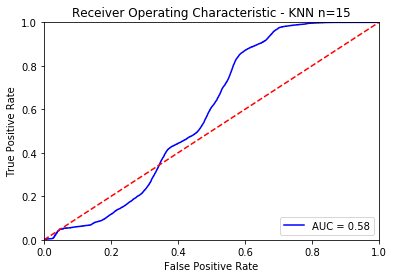


On Test Data - KNN n=17:
1006  |  9104
9250  |  40640 

KNN n=17 ROC:0.5787, precision @ rank n:0.1009


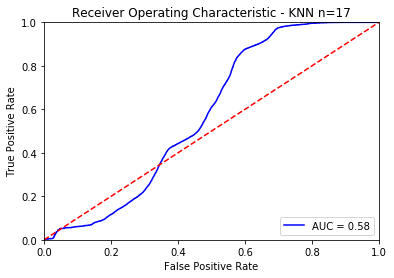


On Test Data - KNN n=19:
1001  |  9108
9255  |  40636 

KNN n=19 ROC:0.5788, precision @ rank n:0.1004


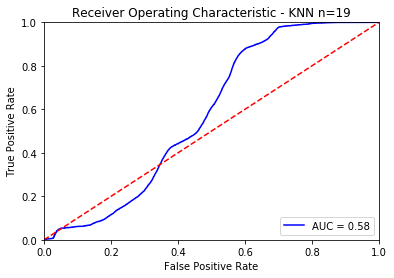

In [14]:
#KNN tests hyperparam variations
neighbors = 1
for i in range (10):
    clf_name ='KNN n=' + str(neighbors)
    clf = KNN(method='largest', contamination= outliers_fraction, n_neighbors=neighbors)
    testMethod(clf, clf_name)

    neighbors = neighbors + 2


On Test Data - LOF:
1056  |  8298
9200  |  41446 

LOF ROC:0.4566, precision @ rank n:0.1103


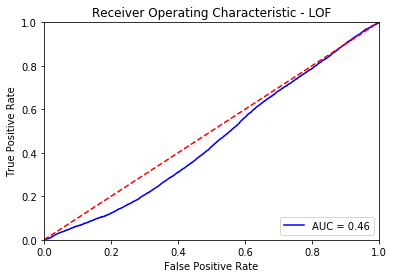


On Test Data - CBLOF:
1215  |  8985
9041  |  40759 

CBLOF ROC:0.5675, precision @ rank n:0.1237


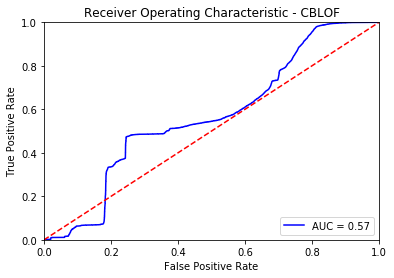


On Test Data - HBOS:
7  |  8818
10249  |  40926 

HBOS ROC:0.5775, precision @ rank n:0.0008


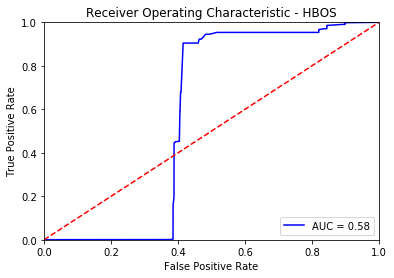


On Test Data - kNN:
960  |  8894
9296  |  40850 

kNN ROC:0.5761, precision @ rank n:0.101


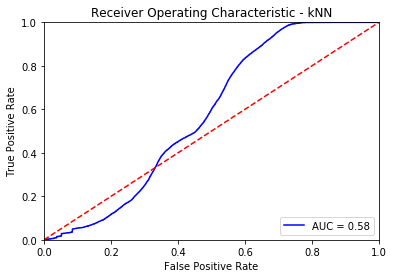


On Test Data - AvgKNN:
874  |  8302
9382  |  41442 

AvgKNN ROC:0.5747, precision @ rank n:0.1006


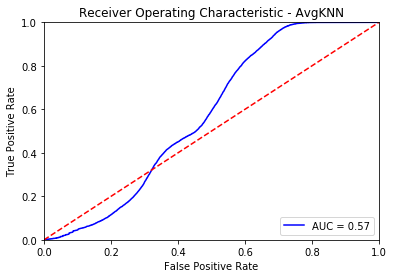


On Test Data - MedKNN:
844  |  8657
9412  |  41087 

MedKNN ROC:0.5725, precision @ rank n:0.0943


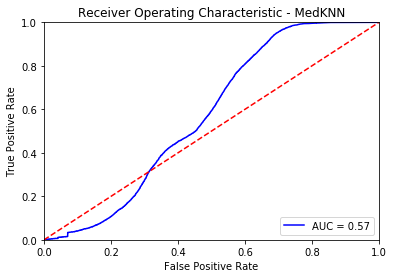


On Test Data - SOD:
1157  |  9043
9099  |  40701 

SOD ROC:0.4864, precision @ rank n:0.1139


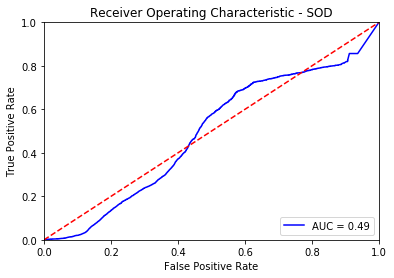

In [13]:
#Proximity Based
classifiers = {
    #'COF': COF(contamination= outliers_fraction),  #Apresentou erros de execução.
    'LOF': LOF(contamination = outliers_fraction),
    'CBLOF':CBLOF(contamination= outliers_fraction),
    #'LOCI':LOCI(contamination= outliers_fraction),   #Travou a máquina de execução repetidas vezes.
    'HBOS': HBOS(contamination= outliers_fraction),
    'kNN': KNN(method='largest', contamination= outliers_fraction),
    'AvgKNN': KNN(method='mean', contamination= outliers_fraction),
    'MedKNN': KNN(method='median', contamination= outliers_fraction),
    'SOD': SOD(contamination= outliers_fraction)
}

for i, (clf_name, clf) in enumerate(classifiers.items()):
    testMethod(clf, clf_name)    